# Predicting Heart Disease using Machine Learning

## Step 1. Problem Definition
> The objective of this project is to develop a machine learning model that can effectively predict the presence or absence of heart disease based on various medical and lifestyle factors.


## Step 2. Import the necessary libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.stats import loguniform
import scipy.stats as stat 
import pylab
%matplotlib inline

## Step 3. Load & prepare the data

Base on the data dictionary, there is a date column. We will parse this column when loading the data.

In [2]:
# Store the data into df dataframe
df = pd.read_csv('data/cardio_data.csv',
                 parse_dates=['date'],
                 dayfirst=True) # parse the date column with dayfirst=True
df.head()

,date,country,id,active,age,alco,ap_hi,ap_lo,cholesterol,gender,gluc,height,occupation,smoke,weight,disease
0,2021-05-03,Indonesia,0,1,18393,0,110,80,1,2,1,168,Architect,0,62.0,0
1,2021-08-05,Malaysia,1,1,20228,0,140,90,3,1,1,156,Accountant,0,85.0,1
2,2022-11-13,Indonesia,2,0,18857,0,130,70,3,1,1,165,Chef,0,64.0,1
3,2018-10-31,Singapore,3,1,17623,0,150,100,1,2,1,169,Lawyer,0,82.0,1
4,2020-09-25,Singapore,4,0,17474,0,100,60,1,1,1,156,Architect,0,56.0,0


### Remove id column

In [3]:
df.drop(['id'], axis=1, inplace=True)
df.head(3)

,date,country,active,age,alco,ap_hi,ap_lo,cholesterol,gender,gluc,height,occupation,smoke,weight,disease
0,2021-05-03,Indonesia,1,18393,0,110,80,1,2,1,168,Architect,0,62.0,0
1,2021-08-05,Malaysia,1,20228,0,140,90,3,1,1,156,Accountant,0,85.0,1
2,2022-11-13,Indonesia,0,18857,0,130,70,3,1,1,165,Chef,0,64.0,1


## Step 4. Clean the data

### Check datatypes

In [4]:
df.dtypes

date           datetime64[ns]
country                object
active                  int64
age                     int64
alco                    int64
ap_hi                   int64
ap_lo                   int64
cholesterol             int64
gender                  int64
gluc                    int64
height                  int64
occupation             object
smoke                   int64
weight                float64
disease                 int64
dtype: object

### Check if there are null values

In [5]:
df.isna().sum()

date           0
country        0
active         0
age            0
alco           0
ap_hi          0
ap_lo          0
cholesterol    0
gender         0
gluc           0
height         0
occupation     0
smoke          0
weight         0
disease        0
dtype: int64

### Since there are no null values, we can check for outliers on our data.

Separate numeric categorical to continuous and put to separate lists

In [6]:
# Create two list for each
categorical_col = []
continuous_col = []

# loop through num list
for col in df.columns:
    if df[col].nunique() <= 10:
        categorical_col.append(col)
    else:
        continuous_col.append(col)

In [7]:
categorical_col

['country',
 'active',
 'alco',
 'cholesterol',
 'gender',
 'gluc',
 'occupation',
 'smoke',
 'disease']

In [8]:
continuous_col

['date', 'age', 'ap_hi', 'ap_lo', 'height', 'weight']

### Now we can check outliers from our continuous numerical columns.

Plot histogram.

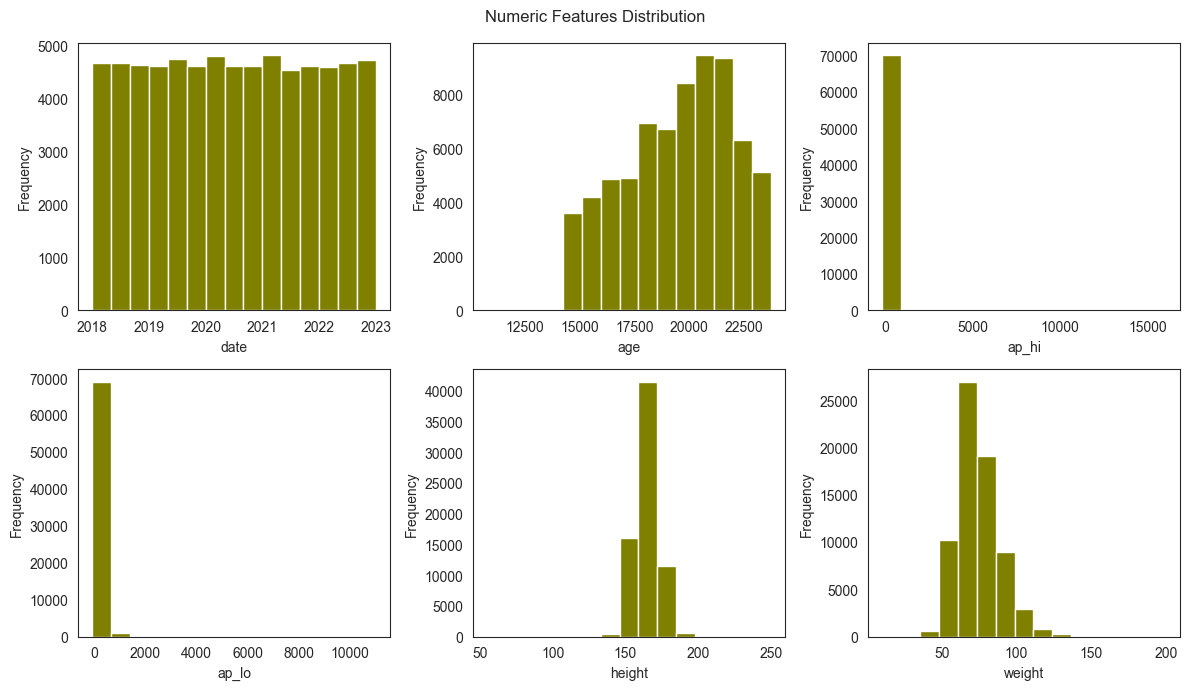

In [9]:
# Set styling
sns.set_style('white')

# Create 2x3 figures to show all 6 graphs
fig, axs = plt.subplots(figsize=(12,7),
                        nrows=2,
                        ncols=3)

# Plot the histogram using for loop
for cont, ax in zip(continuous_col, axs.ravel()):
    ax.hist(df[cont],
            color='olive',
            bins=15)
    ax.set_xlabel(cont)
    ax.set_ylabel('Frequency')

# Set some information
plt.suptitle('Numeric Features Distribution')
plt.tight_layout()
plt.show()

### Handling outliers

There are a lot of outliers from different columns. We need to handle this because this will have a bad effect on our predictions. We will handle it one by one.

We will use a method called winsorization, is a method of setting all the outliers from lower and upper to the value of the lower percentile and upper percentile.

`age` column

In [10]:
# Since winzorization is trial and error I will make a copy of the data
df_new = df.copy()

In [11]:
# Let's make it by year first
df_new['age'] = df_new['age'] / 365 
df_new.head(3)

,date,country,active,age,alco,ap_hi,ap_lo,cholesterol,gender,gluc,height,occupation,smoke,weight,disease
0,2021-05-03,Indonesia,1,50.391781,0,110,80,1,2,1,168,Architect,0,62.0,0
1,2021-08-05,Malaysia,1,55.419178,0,140,90,3,1,1,156,Accountant,0,85.0,1
2,2022-11-13,Indonesia,0,51.663014,0,130,70,3,1,1,165,Chef,0,64.0,1


(array([3529., 3197., 3454., 3250., 2751., 3294., 5396., 6401., 7276.,
        6501., 5193., 4893., 5341., 4601., 4923.]),
 array([39.63287671, 41.30593644, 42.97899616, 44.65205589, 46.32511562,
        47.99817534, 49.67123507, 51.34429479, 53.01735452, 54.69041425,
        56.36347397, 58.0365337 , 59.70959342, 61.38265315, 63.05571288,
        64.7287726 ]),
 <BarContainer object of 15 artists>)

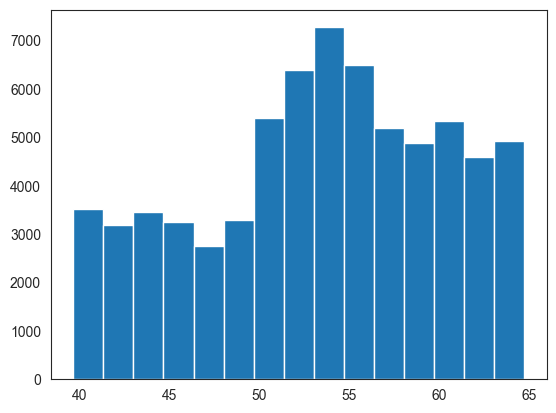

In [12]:
# Make percentile value
lower_percentile = .01
upper_percentile = 0.999

# Use clip method
df_new['age'] = df_new['age'].clip(lower=df_new['age'].quantile(lower_percentile),
                                       upper=df_new['age'].quantile(upper_percentile))

# Check histogram
plt.hist(df_new['age'], bins=15)

Base on this website: https://bloodpressureok.com/reading/140-over-40/

> "Your systole(ap_hi) cannot be higher than 300 or lower than 50. Your diastole(ap_lo) cannot be higher than 200 or lower than 40. Please check your readings"

 We will be using this as a guide to winsorize or to set the min and max of our data from ap_hi and ap_lo.

`ap_hi` column

In [13]:
# Check min and max for ap_hi
df.ap_hi.min(), df.ap_hi.max()

(-150, 16020)

(array([1.3460e+03, 2.6940e+03, 8.9400e+03, 2.7826e+04, 9.5130e+03,
        9.8070e+03, 4.7620e+03, 1.4700e+02, 3.1160e+03, 7.7600e+02,
        7.1300e+02, 1.4400e+02, 1.1700e+02, 2.5000e+01, 7.4000e+01]),
 array([ 90.        ,  98.66666667, 107.33333333, 116.        ,
        124.66666667, 133.33333333, 142.        , 150.66666667,
        159.33333333, 168.        , 176.66666667, 185.33333333,
        194.        , 202.66666667, 211.33333333, 220.        ]),
 <BarContainer object of 15 artists>)

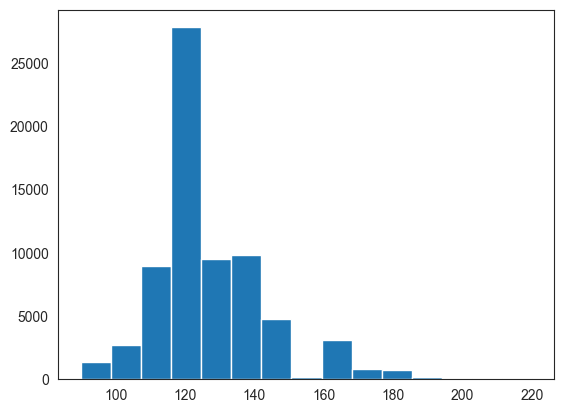

In [14]:
# Make percentile value
lower_percentile = .01
upper_percentile = 0.999

# Use clip method
df_new['ap_hi'] = df_new['ap_hi'].clip(lower=df_new['ap_hi'].quantile(lower_percentile),
                                       upper=df_new['ap_hi'].quantile(upper_percentile))

# Check histogram
plt.hist(df_new['ap_hi'], bins=15)

`ap_lo` column

I will use the same winsorization method.

In [15]:
# Check min and max
df_new['ap_lo'].min(), df_new['ap_lo'].max()

(-70, 11000)

(array([2.9320e+03, 1.2200e+02, 1.0404e+04, 2.7400e+02, 3.5285e+04,
        3.7800e+02, 1.4487e+04, 2.3100e+02, 6.5000e+01, 4.1020e+03,
        3.0000e+01, 4.1100e+02, 1.3000e+01, 2.1100e+02, 1.0550e+03]),
 array([ 60.   ,  64.404,  68.808,  73.212,  77.616,  82.02 ,  86.424,
         90.828,  95.232,  99.636, 104.04 , 108.444, 112.848, 117.252,
        121.656, 126.06 ]),
 <BarContainer object of 15 artists>)

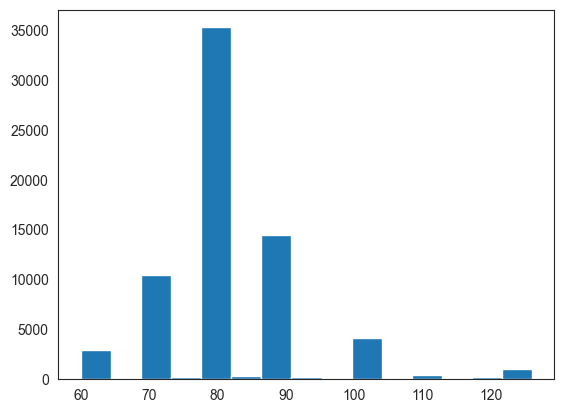

In [16]:
# Make percentile value
lower_percentile = 0.01
upper_percentile = 0.985

# Use clip method
df_new['ap_lo'] = df_new['ap_lo'].clip(lower=df_new['ap_lo'].quantile(lower_percentile),
                                       upper=df_new['ap_lo'].quantile(upper_percentile))

# Check histogram
plt.hist(df_new['ap_lo'], bins=15)

I will apply the same method for outliers in height and weight columns.

`height` column

In [17]:
df_new['height'].min(), df_new['height'].max()

(55, 250)

(array([ 1537.,  2826.,  4284.,  7882.,  8728.,  9169., 10370.,  7190.,
         8007.,  4443.,  2828.,  1488.,   643.,   417.,   188.]),
 array([147.        , 149.86666667, 152.73333333, 155.6       ,
        158.46666667, 161.33333333, 164.2       , 167.06666667,
        169.93333333, 172.8       , 175.66666667, 178.53333333,
        181.4       , 184.26666667, 187.13333333, 190.        ]),
 <BarContainer object of 15 artists>)

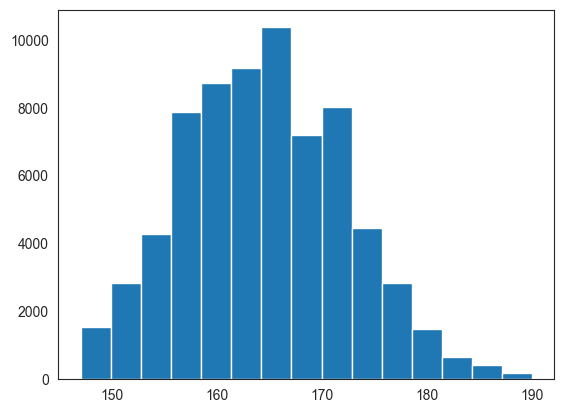

In [18]:
# Make percentile value
lower_percentile = 0.01
upper_percentile = 0.999

# Use clip method
df_new['height'] = df_new['height'].clip(lower=df_new['height'].quantile(lower_percentile),
                                         upper=df_new['height'].quantile(upper_percentile))

# Check histogram
plt.hist(df_new['height'], bins=15)

`weight` column

In [19]:
df_new['weight'].min(), df_new['weight'].max()

(10.0, 200.0)

(array([5.0760e+03, 1.5717e+04, 1.8905e+04, 1.4467e+04, 7.9380e+03,
        4.6460e+03, 1.7510e+03, 8.6100e+02, 3.4500e+02, 1.5700e+02,
        5.2000e+01, 3.0000e+01, 1.9000e+01, 2.2000e+01, 1.4000e+01]),
 array([ 48. ,  56.8,  65.6,  74.4,  83.2,  92. , 100.8, 109.6, 118.4,
        127.2, 136. , 144.8, 153.6, 162.4, 171.2, 180. ]),
 <BarContainer object of 15 artists>)

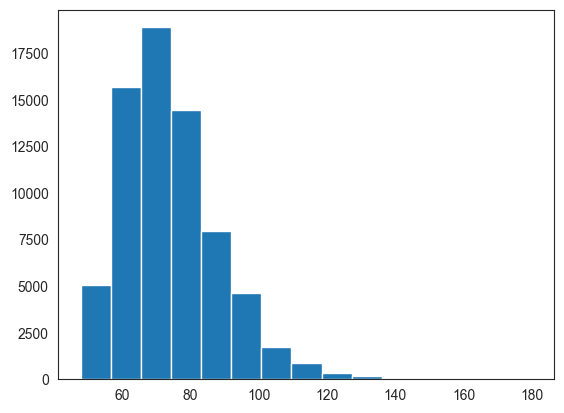

In [20]:
# Make percentile value
lower_percentile = 0.01
upper_percentile = 0.9999

# Use clip method
df_new['weight'] = df_new['weight'].clip(lower=df_new['weight'].quantile(lower_percentile),
                                         upper=df_new['weight'].quantile(upper_percentile))

# Check histogram
plt.hist(df_new['weight'], bins=15)

Now that we handle most of the outliers, let's copy back our df_new to our original df.

In [21]:
df = df_new.copy()

## Step 5. Feature Engineering

### Dates processing

Before we can visualize dates, we need to process it first, we will separate this to year, month and day columns.

In [22]:
# Create a function that returns year and month for all the date column
def process_date(df):
    """
    This function filters all the date column datatypes in the whole dataset and create a year, month and day column for each of the date columns.
    """
    # First filter all the date columns and put it into a list
    df_col = df.columns.tolist()
    date_col = []
    for col in df_col:
        if df[col].dtype == '<M8[ns]':
            date_col.append(col)
    
    # Create year column for each date column
    for date in date_col:
        df[date + '_year'] = df[date].dt.year
        
    # Create month column for each date column
    for month in date_col:
        df[month + '_month'] = df[month].dt.month

    # Create day column for each date column
    for day in date_col:
        df[day + '_day'] = df[day].dt.day
    
    # Drop the original dates column
    df.drop(date_col, axis = 1, inplace=True)
    
    return df

In [23]:
process_date(df)

,country,active,age,alco,ap_hi,ap_lo,cholesterol,gender,gluc,height,occupation,smoke,weight,disease,date_year,date_month,date_day
0,Indonesia,1,50.391781,0,110,80.0,1,2,1,168,Architect,0,62.0,0,2021,5,3
1,Malaysia,1,55.419178,0,140,90.0,3,1,1,156,Accountant,0,85.0,1,2021,8,5
2,Indonesia,0,51.663014,0,130,70.0,3,1,1,165,Chef,0,64.0,1,2022,11,13
3,Singapore,1,48.282192,0,150,100.0,1,2,1,169,Lawyer,0,82.0,1,2018,10,31
4,Singapore,0,47.873973,0,100,60.0,1,1,1,156,Architect,0,56.0,0,2020,9,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,Singapore,1,52.712329,0,120,80.0,1,2,1,168,Doctor,1,76.0,0,2018,4,3
69996,Malaysia,1,61.920548,0,140,90.0,2,1,2,158,Accountant,0,126.0,1,2022,1,12
69997,Malaysia,0,52.235616,1,180,90.0,3,2,1,183,Accountant,0,105.0,1,2022,8,25
69998,Singapore,0,61.454795,0,135,80.0,1,1,2,163,Accountant,0,72.0,1,2020,7,13


### Create BMI feature out of height and weight columns

* Formula for BMI is weight in kg divided by height in meters squared.

In [24]:
# Execute the BMI formula
df['bmi'] = df['weight'] / (df['height'] / 100) ** 2
df.head(3)

,country,active,age,alco,ap_hi,ap_lo,cholesterol,gender,gluc,height,occupation,smoke,weight,disease,date_year,date_month,date_day,bmi
0,Indonesia,1,50.391781,0,110,80.0,1,2,1,168,Architect,0,62.0,0,2021,5,3,21.967120
1,Malaysia,1,55.419178,0,140,90.0,3,1,1,156,Accountant,0,85.0,1,2021,8,5,34.927679
2,Indonesia,0,51.663014,0,130,70.0,3,1,1,165,Chef,0,64.0,1,2022,11,13,23.507805


In [25]:
# Drop height and weight
df.drop(['height', 'weight'], axis=1, inplace=True)
df.head(3)

,country,active,age,alco,ap_hi,ap_lo,cholesterol,gender,gluc,occupation,smoke,disease,date_year,date_month,date_day,bmi
0,Indonesia,1,50.391781,0,110,80.0,1,2,1,Architect,0,0,2021,5,3,21.967120
1,Malaysia,1,55.419178,0,140,90.0,3,1,1,Accountant,0,1,2021,8,5,34.927679
2,Indonesia,0,51.663014,0,130,70.0,3,1,1,Chef,0,1,2022,11,13,23.507805


In [27]:
df.to_csv('data/cardio_data_clean.csv', index=False)

## Step 6. Exploratory Data Analysis

### Plot the dates columns

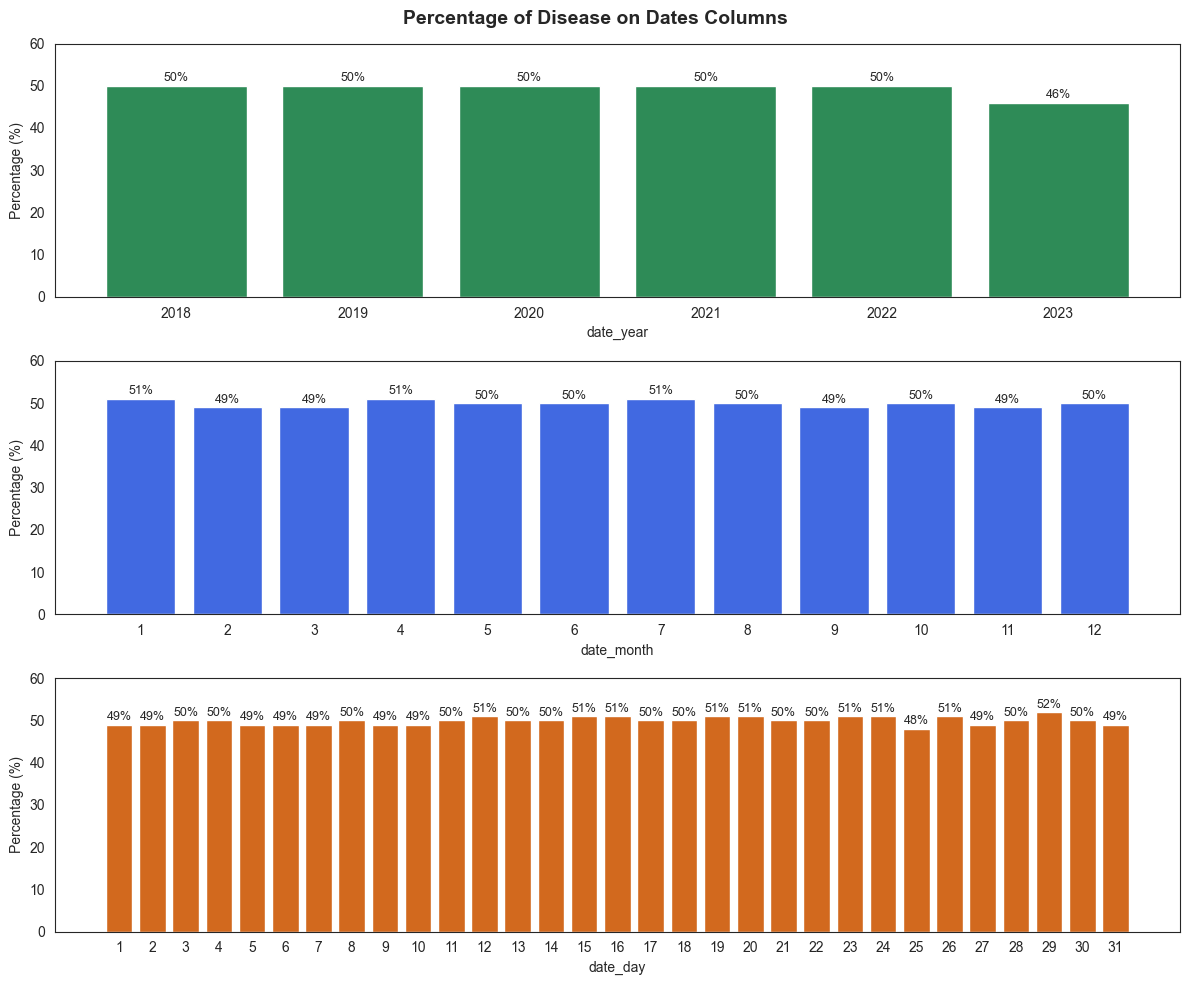

In [ ]:
# Create subplots for plotting every dates
fig, axs = plt.subplots(figsize=(12,10),
                        nrows=3,
                        ncols=1)

# Create a list for all the dates columns
dates_col = ['date_year', 'date_month', 'date_day']

# List of colors
colors = ['seagreen', 'royalblue', 'chocolate']

# Use for loop to plot everything
for col, ax, c in zip(dates_col, axs.ravel(), colors):
    # Get the values of x-axis as list
    date_x = list(range(df[col].min(), df[col].max()+1))

    # Get the percentage of disease first using another for loop
    dis_perc = []
    for i in range(df[col].min(), df[col].max()+1):
        disease_count = df[col][df[col] == i][df['disease'] == 1].count() # count of the total number of disease per date
        percentage = disease_count / df[col][df[col] == i].count() # count of the total number of instances per date
        dis_perc.append(round(percentage * 100))

    # Plot a bar chart 
    bars = ax.bar(date_x, dis_perc, color=c)

    # Annotate bars to set some information
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0,1),
                    textcoords='offset points',
                    ha='center',
                    va='bottom',
                    size=9)
    
    # Set some information
    ax.set_xlabel(col)
    ax.set_xticks(range(df[col].min(), df[col].max()+1))
    ax.set_ylabel('Percentage (%)')
    ax.set_ylim(0, 60)

fig.suptitle('Percentage of Disease on Dates Columns', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

### Plot other categorical features

In [ ]:
categorical_col

['country',
 'active',
 'alco',
 'cholesterol',
 'gender',
 'gluc',
 'occupation',
 'smoke',
 'disease']

Remove target feature from list

In [ ]:
categorical_col.remove('disease')
categorical_col

['country',
 'active',
 'alco',
 'cholesterol',
 'gender',
 'gluc',
 'occupation',
 'smoke']

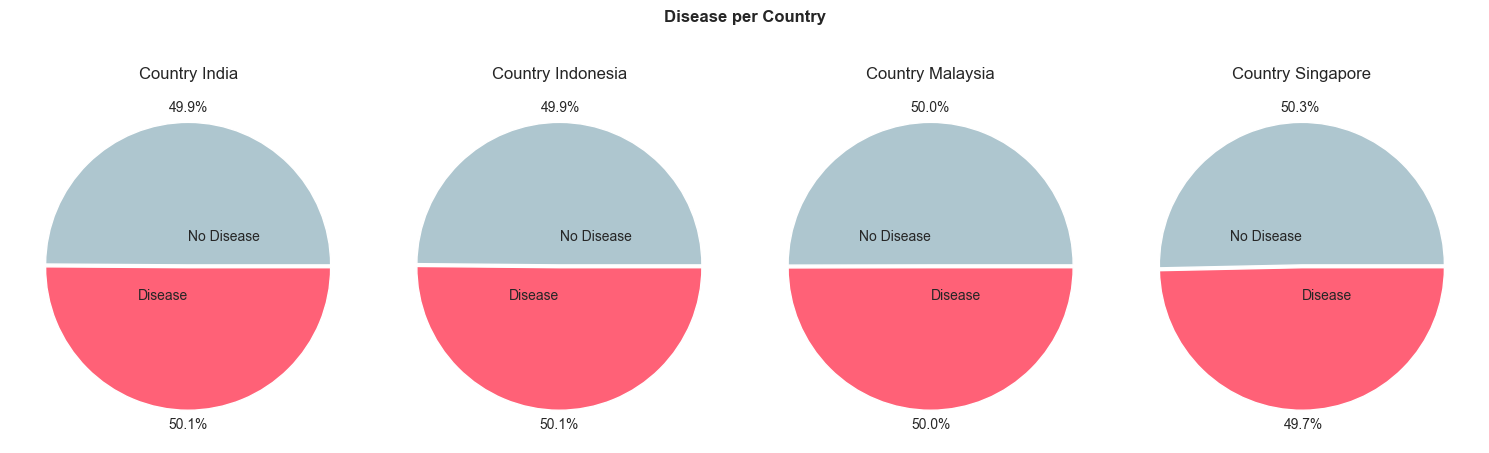

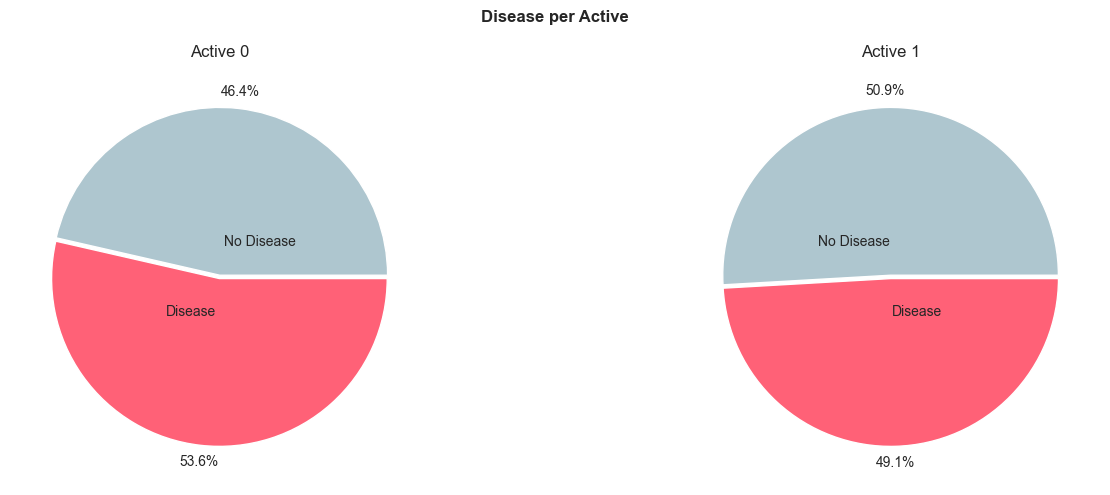

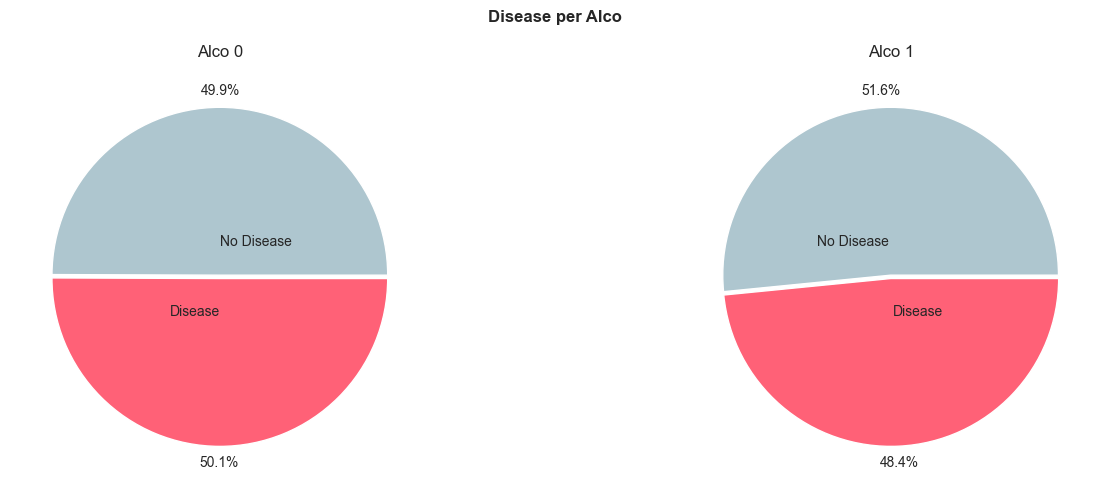

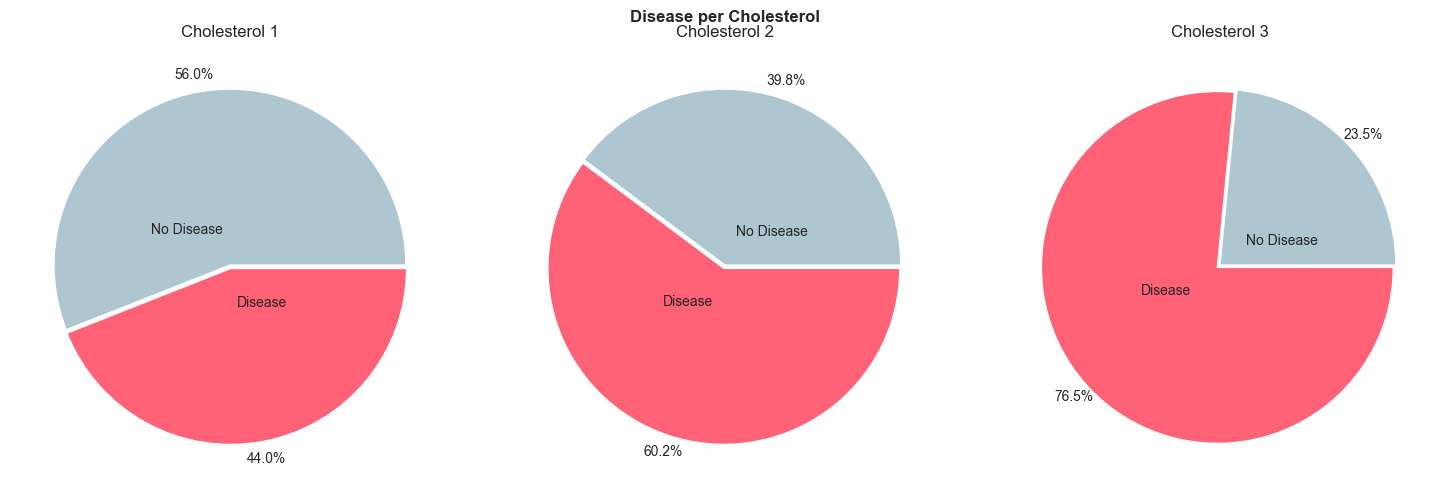

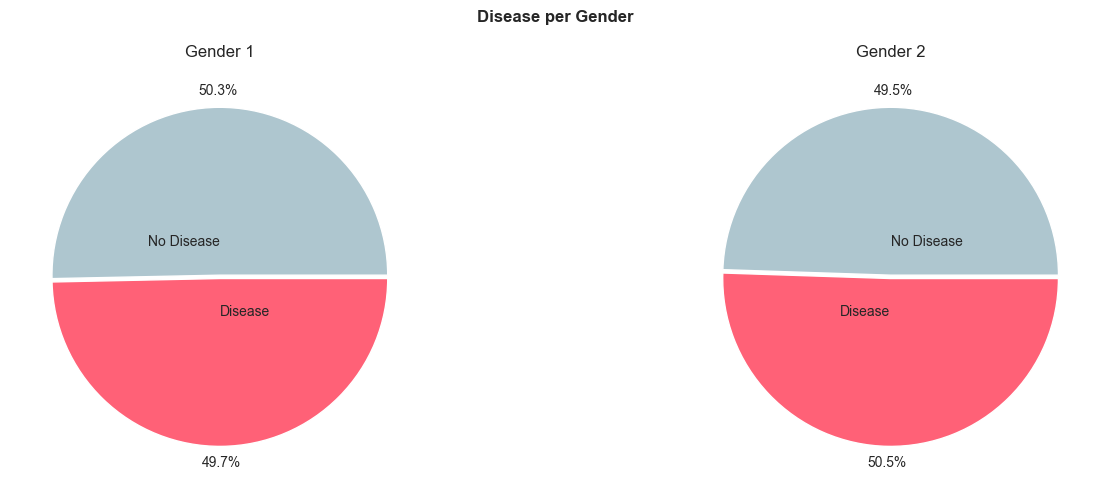

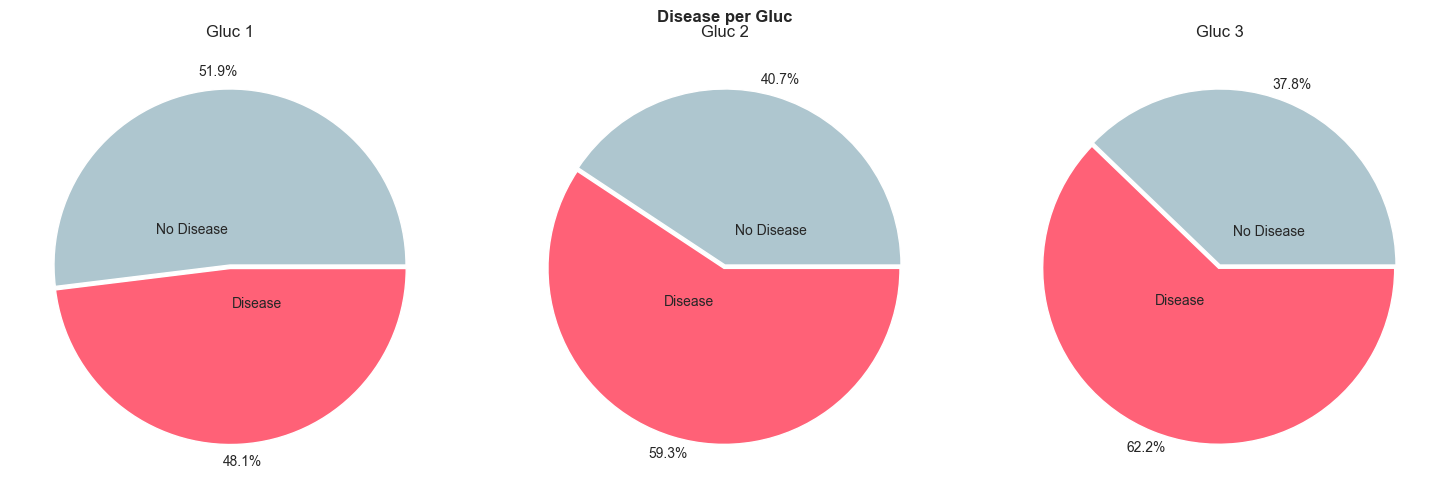

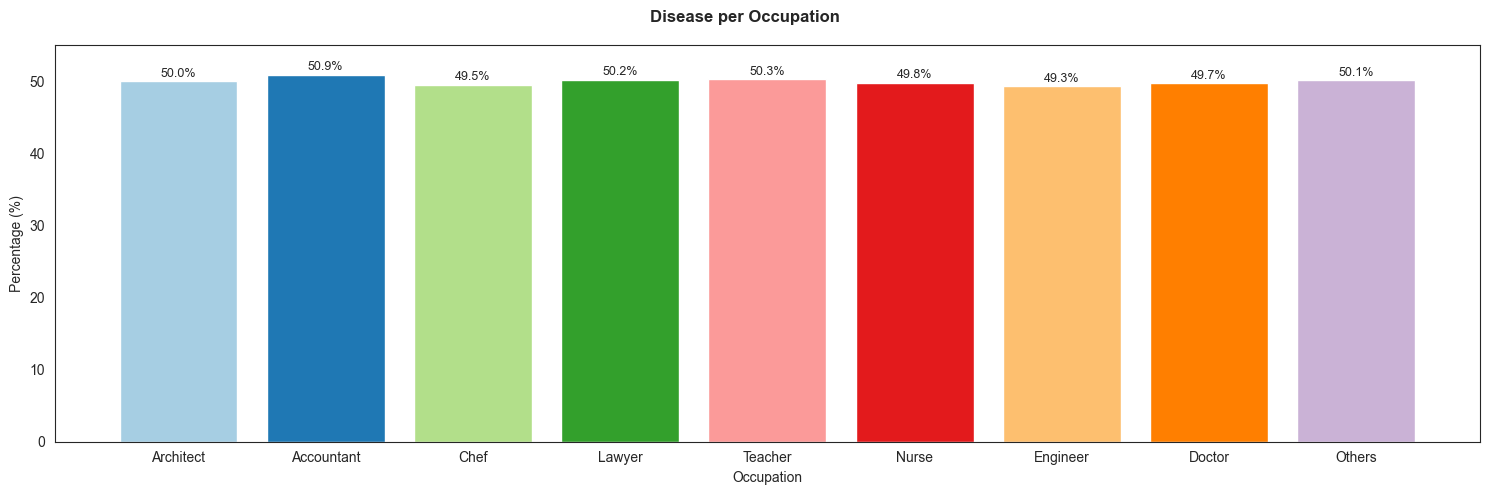

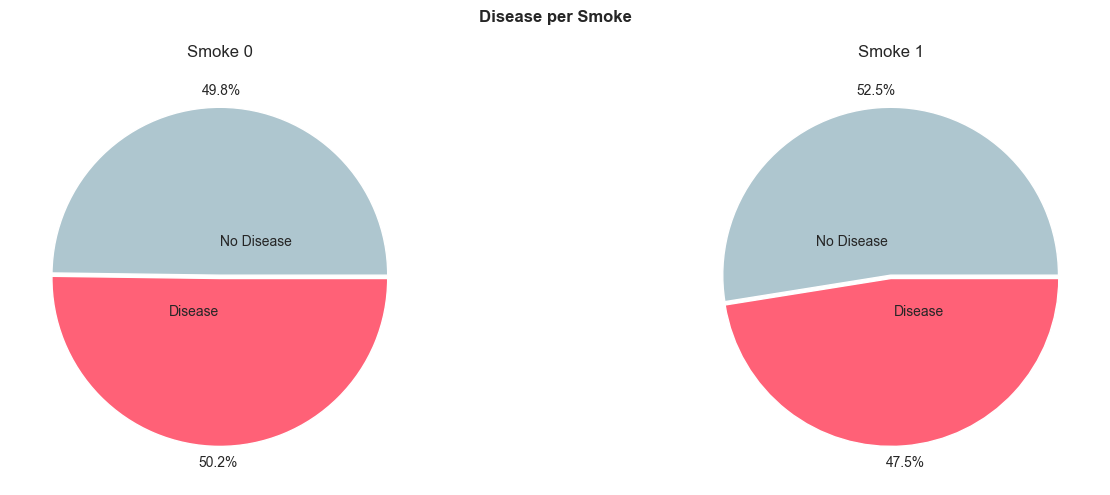

In [ ]:
# Plot pie chart for unique values lower than 5
for feat in categorical_col:

    # For pie chart
    if df[feat].nunique() <= 4:
        fig, axs = plt.subplots(figsize=(15,5),
                                nrows=1,
                                ncols=df[feat].nunique())
        # Set colors
        colors = ['#AEC6CF', '#ff6177']
        
        # Get all the unique values
        cat_val = df[feat].unique()
        cat_val.sort() # sort the values

        for uniq, ax in zip(cat_val, axs.ravel()):
            # Separate the count of disease per value of feature
            uniq_val = df[df[feat] == uniq]
            uniq_val = uniq_val.groupby('disease').size()
            # Set some colors
            sns.set_palette = colors

            # Plot the pie charts
            ax.pie(uniq_val, 
                   labels=['No Disease', 'Disease'],
                   autopct='%1.1f%%',
                   pctdistance=1.1,
                   labeldistance=0.2,
                   explode=(0, 0.02),
                   colors=colors)
            
            # Set title for each features
            ax.set_title(f'{feat.title()} {uniq}')

            # Set main title
            fig.suptitle(f'Disease per {feat.title()}', fontweight='bold')

    else:
        # Plot bar chart for more than 4 unique values
        fig, ax = plt.subplots(figsize=(15,5))
        
        # Create values for x-axis
        feat_x = df[feat].unique()

        # Create a list for disease percentage
        dis_perc = []
        for i in feat_x:
            disease_count = df[feat][df[feat] == i][df['disease'] == 1].count() # Count of the disease per feature value
            percentage = disease_count / df[feat][df[feat] == i].count() # Percentage - dividing the disease count to overall count
            dis_perc.append(round((percentage * 100), 1))

        # Plot bar chart
        bars = ax.bar(feat_x, 
                      dis_perc,
                      color=sns.color_palette('Paired'))

        # Annotate bars
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0,1),
                        textcoords='offset points',
                        ha='center',
                        va='bottom',
                        size=9)
            
        # Set some information
        ax.set_xlabel(feat.title())
        ax.set_ylabel('Percentage (%)')
        ax.set_ylim(0, 55) # Need to set ylim so annotate can fit
        fig.suptitle(f'Disease per {feat.title()}', fontweight='bold')

    plt.tight_layout()
    plt.show()

In [ ]:
df.head()

,country,active,age,alco,ap_hi,ap_lo,cholesterol,gender,gluc,occupation,smoke,disease,date_year,date_month,date_day,bmi
0,Indonesia,1,50.391781,0,110,80.0,1,2,1,Architect,0,0,2021,5,3,21.967120
1,Malaysia,1,55.419178,0,140,90.0,3,1,1,Accountant,0,1,2021,8,5,34.927679
2,Indonesia,0,51.663014,0,130,70.0,3,1,1,Chef,0,1,2022,11,13,23.507805
3,Singapore,1,48.282192,0,150,100.0,1,2,1,Lawyer,0,1,2018,10,31,28.710479
4,Singapore,0,47.873973,0,100,60.0,1,1,1,Architect,0,0,2020,9,25,23.011177


### Visualize other numerical categories

In [ ]:
# Check our continuous list
continuous_col

['date', 'age', 'ap_hi', 'ap_lo', 'height', 'weight']

In [ ]:
# Let's remove dates since it is already visualize
continuous_col.remove('date')

# Remove height and weight since it is already converted into bmi
continuous_col.remove('height')
continuous_col.remove('weight')

# Add bmi to the list
continuous_col.append('bmi')

continuous_col

['age', 'ap_hi', 'ap_lo', 'bmi']

### Plot ap_hi vs ap_lo

I want to observe the relationship of ap_hi and ap_lo together with other features, such as the target feature/disease, the cholesterol and glucose

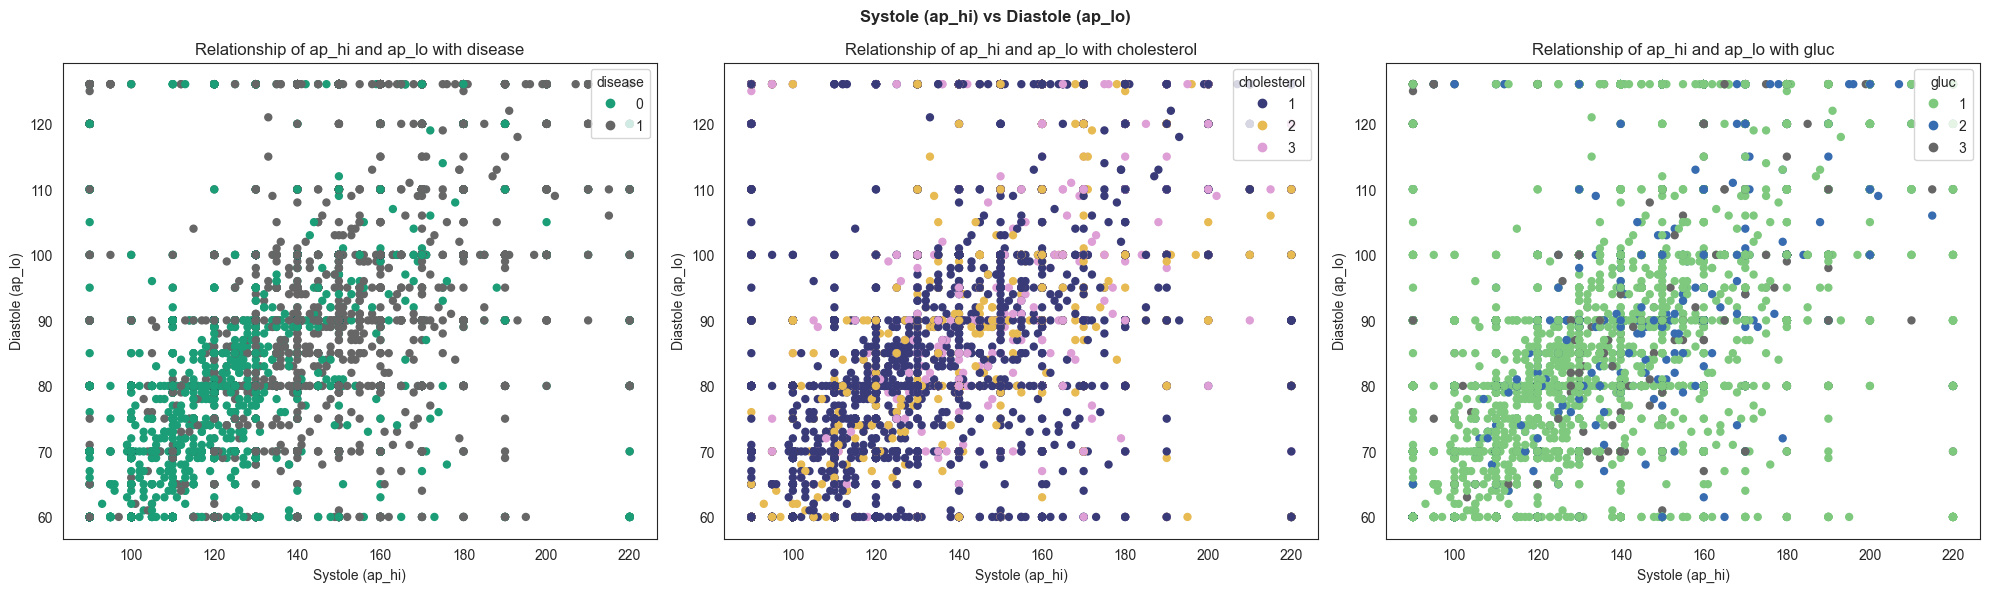

In [ ]:
fig, axs = plt.subplots(figsize=(20,6),
                        nrows=1,
                        ncols=3)

# Make a list of the features we want to present
feature_list = ['disease', 'cholesterol', 'gluc']

# Set some colors
c_maps = ['Dark2', 'tab20b', 'Accent']

# Plot all the scatter using for loop
for feat, cmaps, ax in zip(feature_list, c_maps, axs.ravel()):

    # The main scatter plot
    scatter = ax.scatter(x=df['ap_hi'],
                         y=df['ap_lo'],
                         c=df[feat],
                         cmap=cmaps,
                         s=25)
    
    # Set some information
    ax.legend(*scatter.legend_elements(), title=feat, loc=1) # loc=1 upper right
    ax.set_xlabel('Systole (ap_hi)')
    ax.set_ylabel('Diastole (ap_lo)')
    ax.set_title(f'Relationship of ap_hi and ap_lo with {feat}')

fig.suptitle('Systole (ap_hi) vs Diastole (ap_lo)', fontweight='bold')
plt.tight_layout()
plt.show()

### Plot the age vs bmi

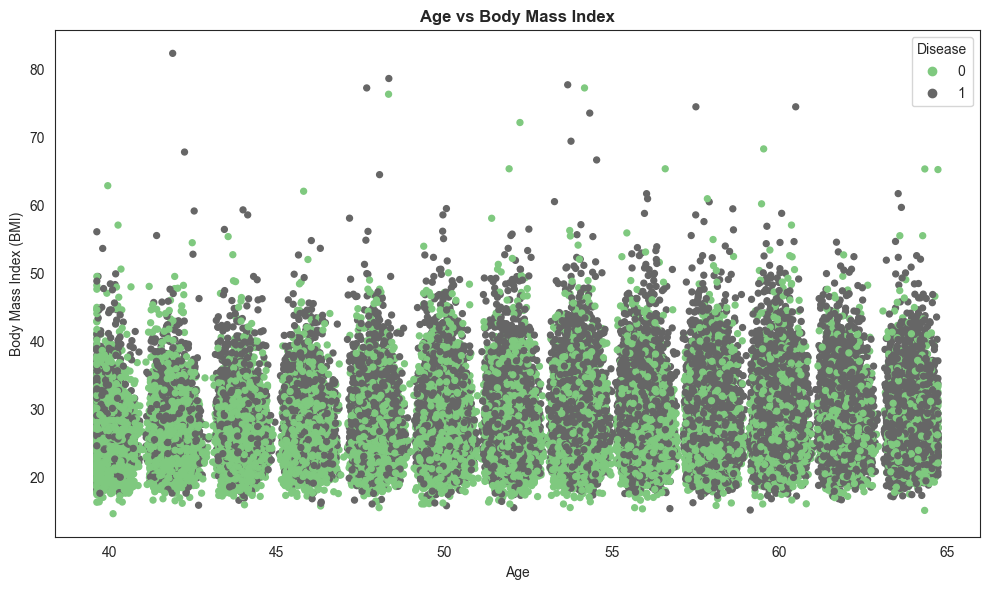

In [ ]:
# Create fugure
fig, ax = plt.subplots(figsize=(10,6))

# Plot using scatter plot
scatter = ax.scatter(x=df['age'],
                     y=df['bmi'],
                     c=df['disease'],
                     cmap='Accent',
                     s=18)

# Set some information
ax.legend(*scatter.legend_elements(), title='Disease', loc=1)
ax.set_xlabel('Age')
ax.set_ylabel('Body Mass Index (BMI)')
ax.set_title('Age vs Body Mass Index', fontweight='bold')

plt.tight_layout()
plt.show()

### Final look at the correlation

In [ ]:
# Move the target column to the last columns first
target_column = 'disease'
df = df[[col for col in df.columns if col != target_column] + [target_column]]

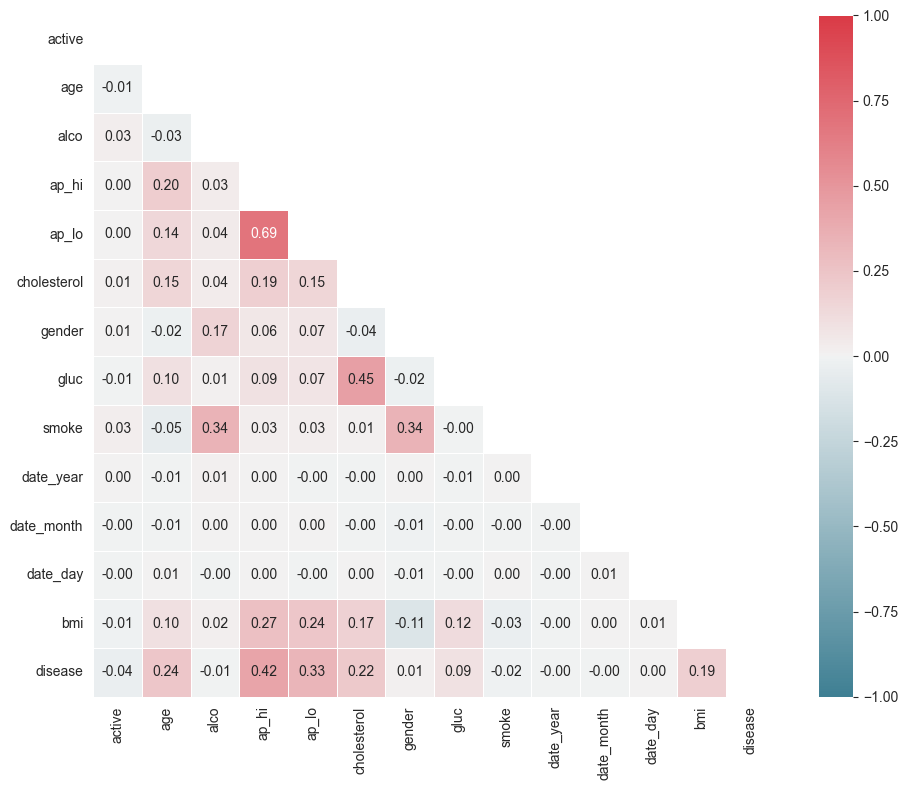

In [ ]:
# Let's make our correlation matrix a little prettier
corr_matrix = df.select_dtypes(include='number').corr() # using select_dtypes to filter all numeric

# Plot the correlation
fig, ax = plt.subplots(figsize=(10,8))

# Set the matrix mask
matrix=np.triu(corr_matrix)

#Set the color
colors = sns.diverging_palette(220, 10, as_cmap=True)

ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt='.2f',
                 cmap=colors,
                 mask=matrix,
                 square=True,
                 vmin=-1,
                 vmax=1)

plt.tight_layout()
plt.show()

## Step 7. Data Preprocessing

We have to preprocess the data, this includes the following:

1. Creating X & y
2. Cyclic encode the dates
3. Encoding Categorical features
4. Split the data
5. Feature scaling

### Create X & y

Cyclic encoding of the dates is important to show the model that these values are recurring. This will be performed only on day and month columns only.

In [ ]:
df.head()

,country,active,age,alco,ap_hi,ap_lo,cholesterol,gender,gluc,occupation,smoke,date_year,date_month,date_day,bmi,disease
0,Indonesia,1,50.391781,0,110,80.0,1,2,1,Architect,0,2021,5,3,21.967120,0
1,Malaysia,1,55.419178,0,140,90.0,3,1,1,Accountant,0,2021,8,5,34.927679,1
2,Indonesia,0,51.663014,0,130,70.0,3,1,1,Chef,0,2022,11,13,23.507805,1
3,Singapore,1,48.282192,0,150,100.0,1,2,1,Lawyer,0,2018,10,31,28.710479,1
4,Singapore,0,47.873973,0,100,60.0,1,1,1,Architect,0,2020,9,25,23.011177,0


In [ ]:
X = df.drop('disease', axis=1)
y = df['disease']

### Cyclic encoding

Cyclic encoding is done to encode date values particularly month and day to tell the model that these values are recurring.

Create a function that will encode dates cyclically.

In [ ]:
def cyclic_encode(df, column_list, year_column_list):
    """
    This function analyze a given dataset with the given month/day column list and year column list. 
    It will determine first if year is a leap year then proceed to encode the proper count of days for February.
    """
    # Import library needed
    import calendar
    
    # Iterate through the list to get the column name
    for col in column_list:
        # Create an if function to check if the column name is month
        if df[col].max() <= 12:
            # Perform cyclic encoding for month
            df[col+'_sin'] = np.sin(2 * np.pi * df[col] / 12)
            df[col+'_cos'] = np.cos(2 * np.pi * df[col] / 12)

        # This will now perform encoding for day column
        elif df[col].max() > 12:
            for year_col in year_column_list:  # Iterate through year columns
                for i, row in enumerate(df[year_col]):
                    # Check if it's a leap year
                    is_leap_year = calendar.isleap(row)
                    
                    # Adjust divisor based on the number of days in the month
                    if col in [1, 3, 5, 7, 8, 10, 12]:
                        divisor = 31
                    elif col == 2:
                        divisor = 29 if is_leap_year else 28
                    else:
                        divisor = 30
                    # Perform cyclic encoding for day
                    df.at[i, col + '_sin'] = np.sin(2 * np.pi * df.at[i, col] / divisor)
                    df.at[i, col + '_cos'] = np.cos(2 * np.pi * df.at[i, col] / divisor)

        # Drop the original dates column
        df.drop(col, axis=1, inplace=True)
    
    return df

Encode the date_month & date_day columns

In [ ]:
# Create a list for the day & months columns
date_col = ['date_month', 'date_day']

# Make a list also for year
year_col = ['date_year']

# Perform cyclic encoding
cyclic_encode(df=X,
              column_list=date_col,
              year_column_list=year_col)

,country,active,age,alco,ap_hi,ap_lo,cholesterol,gender,gluc,occupation,smoke,date_year,bmi,date_month_sin,date_month_cos,date_day_sin,date_day_cos
0,Indonesia,1,50.391781,0,110,80.0,1,2,1,Architect,0,2021,21.967120,0.500000,-8.660254e-01,5.877853e-01,0.809017
1,Malaysia,1,55.419178,0,140,90.0,3,1,1,Accountant,0,2021,34.927679,-0.866025,-5.000000e-01,8.660254e-01,0.500000
2,Indonesia,0,51.663014,0,130,70.0,3,1,1,Chef,0,2022,23.507805,-0.500000,8.660254e-01,4.067366e-01,-0.913545
3,Singapore,1,48.282192,0,150,100.0,1,2,1,Lawyer,0,2018,28.710479,-0.866025,5.000000e-01,2.079117e-01,0.978148
4,Singapore,0,47.873973,0,100,60.0,1,1,1,Architect,0,2020,23.011177,-1.000000,-1.836970e-16,-8.660254e-01,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,Singapore,1,52.712329,0,120,80.0,1,2,1,Doctor,1,2018,26.927438,0.866025,-5.000000e-01,5.877853e-01,0.809017
69996,Malaysia,1,61.920548,0,140,90.0,2,1,2,Accountant,0,2022,50.472681,0.500000,8.660254e-01,5.877853e-01,-0.809017
69997,Malaysia,0,52.235616,1,180,90.0,3,2,1,Accountant,0,2022,31.353579,-0.866025,-5.000000e-01,-8.660254e-01,0.500000
69998,Singapore,0,61.454795,0,135,80.0,1,1,2,Accountant,0,2020,27.099251,-0.500000,-8.660254e-01,4.067366e-01,-0.913545


### Encoding categorical features

In [ ]:
# Filter all the object types and those with max values less than 5
X_cat = [col for col in X.columns if X[col].dtype == 'O' or X[col].max() < 5]

# Remove the dates columns
X_cat = X_cat[:8]

X_cat

['country',
 'active',
 'alco',
 'cholesterol',
 'gender',
 'gluc',
 'occupation',
 'smoke']

One hot encode every categorical feature using pandas `get_dummies()`

In [ ]:
# Using our list to pass as the columns
X = pd.get_dummies(X,
                   columns=X_cat,
                   dtype=int)

X.head(3)

,age,ap_hi,ap_lo,date_year,bmi,date_month_sin,date_month_cos,date_day_sin,date_day_cos,country_India,...,occupation_Architect,occupation_Chef,occupation_Doctor,occupation_Engineer,occupation_Lawyer,occupation_Nurse,occupation_Others,occupation_Teacher,smoke_0,smoke_1
0,50.391781,110,80.0,2021,21.967120,0.500000,-0.866025,0.587785,0.809017,0,...,1,0,0,0,0,0,0,0,1,0
1,55.419178,140,90.0,2021,34.927679,-0.866025,-0.500000,0.866025,0.500000,0,...,0,0,0,0,0,0,0,0,1,0
2,51.663014,130,70.0,2022,23.507805,-0.500000,0.866025,0.406737,-0.913545,0,...,0,1,0,0,0,0,0,0,1,0


### Split the data set into training, validation and test set

We will be using validation set for hyperparameter tuning to save time.

In [ ]:
# Import train_test_split as tts
from sklearn.model_selection import train_test_split as tts

# Create temporary set
X_train, X_temp, y_train, y_temp = tts(X, y, test_size=0.30, random_state=42)

# Split further the temporary set to create a 70%, 15%, 15% dataset split
X_val, X_test, y_val, y_test = tts(X_temp, y_temp, test_size=0.50, random_state=42)

# Check the shapes
X_train.shape, X_val.shape, X_test.shape

((49000, 36), (10500, 36), (10500, 36))

### Feature Scaling

In [ ]:
# Get all the remaining numeric features to encode
scale_col = [col for col in X_train.columns if X_train[col].max() > 4]
scale_col

['age', 'ap_hi', 'ap_lo', 'date_year', 'bmi']

In [ ]:
# Import library
from sklearn.preprocessing import StandardScaler

# Instantiate the StandardScaler
sc = StandardScaler()

# Always use fit_transform for the train set
X_train[scale_col] = sc.fit_transform(X_train[scale_col])

# Use transform only for other set like validation and test
X_val[scale_col] = sc.transform(X_val[scale_col])
X_test[scale_col] = sc.transform(X_test[scale_col])

X_train.head(3)

,age,ap_hi,ap_lo,date_year,bmi,date_month_sin,date_month_cos,date_day_sin,date_day_cos,country_India,...,occupation_Architect,occupation_Chef,occupation_Doctor,occupation_Engineer,occupation_Lawyer,occupation_Nurse,occupation_Others,occupation_Teacher,smoke_0,smoke_1
68681,0.388149,-0.399588,0.746770,1.411251,-0.477011,0.500000,-0.866025,0.743145,-0.669131,0,...,0,0,0,0,1,0,0,0,1,0
19961,1.309275,-0.399588,-0.181509,-0.711734,-0.802001,-0.500000,0.866025,0.587785,-0.809017,0,...,1,0,0,0,0,0,0,0,1,0
11040,1.347368,-0.399588,0.746770,0.703589,-0.327070,0.866025,0.500000,0.587785,0.809017,0,...,0,0,0,0,1,0,0,0,1,0


## Step 7. Modelling

Now that we have preprocess our data. We can now experiment on different models.

We select right estimators base on scikit-learn meachine learning model map: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

1. Perform baseline model (no hyperparameter tuning) using the following models:
    * SVM with linear kernel
    * Naive Bayes
    * KNearestNeighbors
    * RandomForestClassifiers
    * XGBoost
2. Score each model.
3. Hyperparameter tuning using RandomSearchCV

In [ ]:
# Import library for accuracy score
from sklearn.metrics import accuracy_score

# Create a fucntion that will take 3 inputs, y_true value, y_predicted, and the dictionary name
def evaluate_model(y_true, y_predictions, model_name, score_dictionary):
    model_score = accuracy_score(y_true, y_predictions)
    score_dictionary[model_name] = model_score * 100
 
    return score_dictionary

### Baseline model

Upon experimenting, I will be using the validation set to save time.

In [ ]:
# Create a dictionary for the baseline models
baseline_scores = {}

### Linear SVM

In [ ]:
# Import SVC
from sklearn.svm import SVC

# Instatiate SVC
lin_svc = SVC(kernel='linear', random_state=42)

# Fit linear SVC
lin_svc.fit(X_val, y_val)

# Predict using linear svc
y_preds = lin_svc.predict(X_test)

# Evaluate
evaluate_model(y_test, y_preds, 'Linear SVM', baseline_scores)

{'Linear SVM': 72.85714285714285}

### Naive Bayes

In [ ]:
# Import GaussianNB
from sklearn.naive_bayes import GaussianNB

# Since the model doesn't take random_state, we will use random.seed from numpy
np.random.seed(42)

# Instantiate model
nb = GaussianNB()

# Fit naive bayes model
nb.fit(X_val, y_val)

# Predict using naive bayes
y_preds = nb.predict(X_test)

# Evaluate
evaluate_model(y_test, y_preds, 'Naive Bayes', baseline_scores)

{'Linear SVM': 72.85714285714285, 'Naive Bayes': 67.60952380952381}

### KNearest Neighbors

In [ ]:
# Import KNN
from sklearn.neighbors import KNeighborsClassifier

# Since the model doesn't take random_state, we will use random.seed from numpy
np.random.seed(42)

# Instantiate model
knn = KNeighborsClassifier() # Using default neighbors 5

# Fit KNN
knn.fit(X_val, y_val)

# Predict using KNN
y_preds = knn.predict(X_test)

# Evaluate
evaluate_model(y_test, y_preds, 'KNearest Neighbors', baseline_scores)

{'Linear SVM': 72.85714285714285,
 'Naive Bayes': 67.60952380952381,
 'KNearest Neighbors': 67.3047619047619}

### Random Forest Classifiers

In [ ]:
# Import Random Forest
from sklearn.ensemble import RandomForestClassifier

# Instantiate the model
rfc = RandomForestClassifier(random_state=42)

# Fit random forest
rfc.fit(X_val, y_val)

# Predict using random forest
y_preds = rfc.predict(X_test)

# Evaluate
evaluate_model(y_test, y_preds, 'Random Forest', baseline_scores)

{'Linear SVM': 72.85714285714285,
 'Naive Bayes': 67.60952380952381,
 'KNearest Neighbors': 67.3047619047619,
 'Random Forest': 73.00952380952381}

### XGBoost

In [ ]:
# Import XBClassifier
from xgboost import XGBClassifier

# Instantiate the model
xgb = XGBClassifier(random_state=42)

# Fit xgboost
xgb.fit(X_val, y_val)

# Predict using xgboost
y_preds = xgb.predict(X_test)

# Evaluate
evaluate_model(y_test, y_preds, 'XGBoost', baseline_scores)

{'Linear SVM': 72.85714285714285,
 'Naive Bayes': 67.60952380952381,
 'KNearest Neighbors': 67.3047619047619,
 'Random Forest': 73.00952380952381,
 'XGBoost': 71.95238095238096}

### Plot the baseline scores

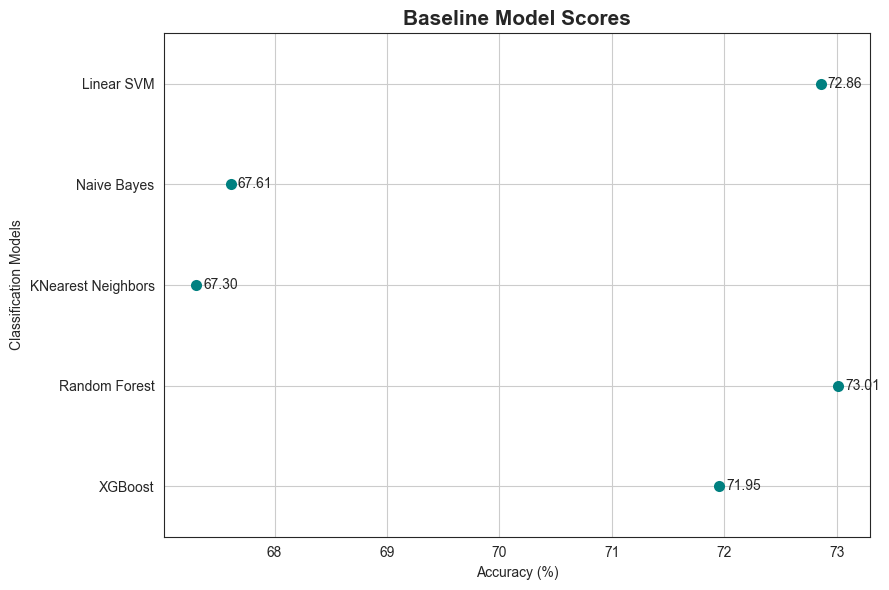

In [ ]:
fig, ax = plt.subplots(figsize=(9,6))

# Plot the stripplot
sns.stripplot(x=baseline_scores.values(), 
              y=baseline_scores.keys(), 
              color='teal',
              size=8, 
              jitter=True, 
              linewidth=0, 
              ax=ax)

# Set some information
ax.set_xlabel('Accuracy (%)')
ax.set_ylabel('Classification Models')
ax.grid(axis='x')
ax.grid(axis='y')
ax.set_title('Baseline Model Scores', fontweight='bold', fontsize=15)

# Annotate the dots
for i, accu in enumerate(baseline_scores.keys()):
    ax.annotate(f'{baseline_scores[accu]:.2f}',
                xy=(baseline_scores[accu], i),
                xytext=(5,0),
                textcoords='offset points',
                ha='left',
                va='center')

plt.tight_layout()
plt.show()

In [ ]:
baseline_scores

{'Linear SVM': 72.85714285714285,
 'Naive Bayes': 67.60952380952381,
 'KNearest Neighbors': 67.3047619047619,
 'Random Forest': 73.00952380952381,
 'XGBoost': 71.95238095238096}

### Confusion Matrix of the Baseline Scores

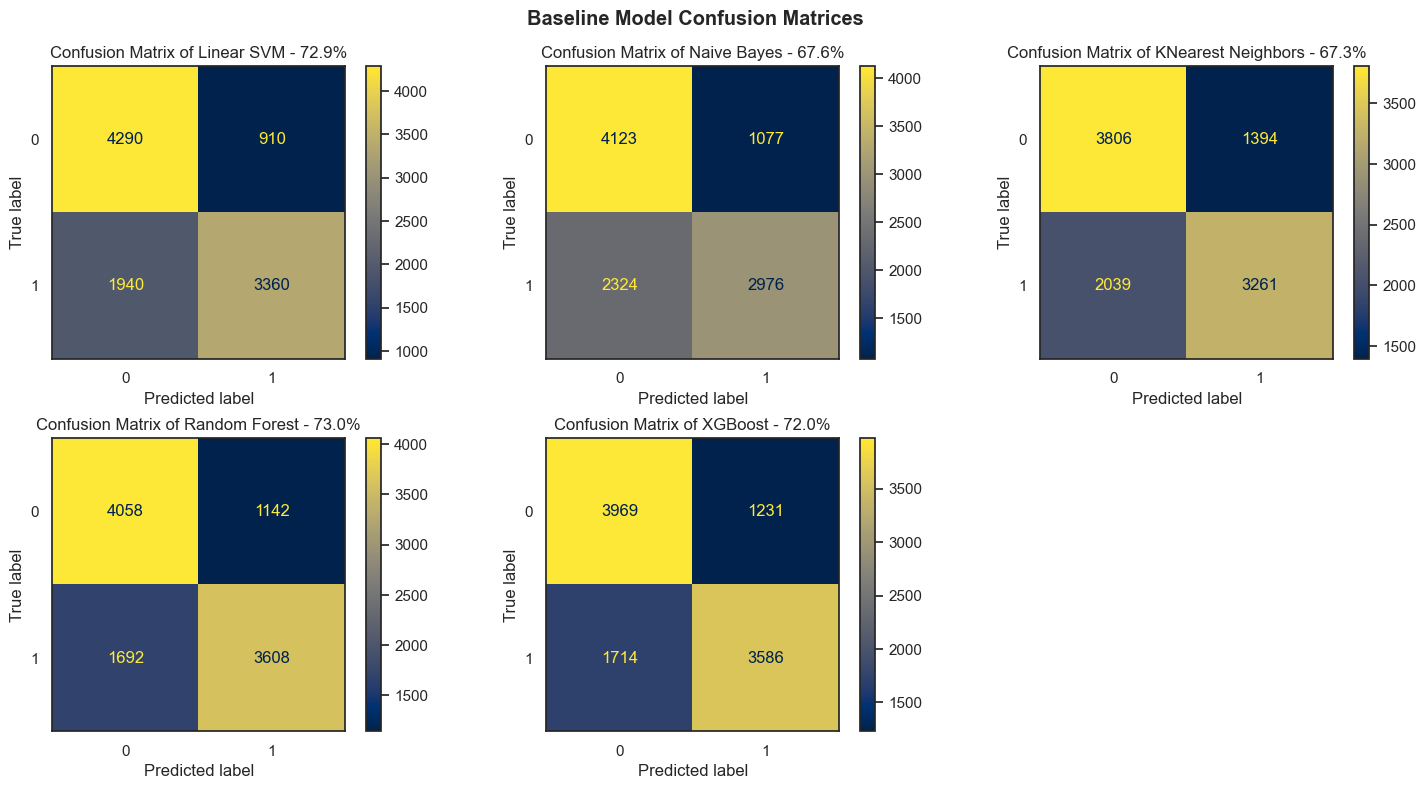

In [ ]:
# Import ConfusionMatrixDisplay from sklearn metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

# Set some styling
sns.set(font_scale=1)
sns.set_style('white')

# Create a dictionary of the baseline models as key and their instance as the value
baseline_models = {'Linear SVM': lin_svc, 'Naive Bayes': nb, 'KNearest Neighbors': knn, 'Random Forest': rfc, 'XGBoost': xgb}

# Create 2 by 3 plot
fig, axes = plt.subplots(nrows=2,
                         ncols=3,
                         figsize=(15,8))

# Flatten the axes for iteration
axes = axes.ravel()

# Use for loop to iterate every model, I also use enumerate so I can get the index for the axes
for i, (model, instance) in enumerate(baseline_models.items()):
    # Since they have the same order and name as the baseline_scores, get the scores also
    score = baseline_scores[model]

    # Make predictions per model
    y_preds = instance.predict(X_test)
    cm = confusion_matrix(y_test, y_preds)

    # Plot the confusion matrix of each model
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='cividis', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix of {model} - {round(score,1)}%')

# Remove any unused subplots
for blank in range(len(baseline_models), len(axes)):
    fig.delaxes(axes[blank])

# Add some information
fig.suptitle('Baseline Model Confusion Matrices', fontweight='bold')
plt.tight_layout()
plt.show()

### Hyperparameter tuning with RandomizedSearchCV

We will use RandomizedSearchCV for quick hyperparameter tuning

In [ ]:
# Create new dictionary for hyperparameter scores
tuning_scores = {}

### RandomizedSearchCV SVM

In [ ]:
# Import RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# Set random seed
np.random.seed(42)

# Instantiate linear SVC
lin_svc = SVC()

# Create grid for hyperparameters
grid = {'C': np.arange(0.1, 2.2, 0.2),
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']}

# Set up RandomizedSearchCV
rs_svc = RandomizedSearchCV(estimator=lin_svc,
                           param_distributions=grid,
                           n_iter=15,
                           cv=5,
                           verbose=2) 
# Fit the RandomizedSearchCV model to the smote set
rs_svc.fit(X_val, y_val)

# Predict from X_test using the best model from RandomizedSearchCV
y_preds = rs_svc.predict(X_test)

# Using the function evaluate score and put into dictionary
evaluate_model(y_test, y_preds, 'Tuned Linear SVM', tuning_scores)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[CV] END ......C=1.9000000000000004, gamma=scale, kernel=rbf; total time=   5.6s
[CV] END ......C=1.9000000000000004, gamma=scale, kernel=rbf; total time=   4.7s
[CV] END ......C=1.9000000000000004, gamma=scale, kernel=rbf; total time=   4.6s
[CV] END ......C=1.9000000000000004, gamma=scale, kernel=rbf; total time=   4.4s
[CV] END ......C=1.9000000000000004, gamma=scale, kernel=rbf; total time=   4.4s
[CV] END ...C=1.3000000000000003, gamma=scale, kernel=linear; total time=   4.4s
[CV] END ...C=1.3000000000000003, gamma=scale, kernel=linear; total time=   4.6s
[CV] END ...C=1.3000000000000003, gamma=scale, kernel=linear; total time=   4.3s
[CV] END ...C=1.3000000000000003, gamma=scale, kernel=linear; total time=   4.5s
[CV] END ...C=1.3000000000000003, gamma=scale, kernel=linear; total time=   4.3s
[CV] END ......C=1.3000000000000003, gamma=scale, kernel=rbf; total time=   4.6s
[CV] END ......C=1.3000000000000003, gamma=scale, kernel=rbf; total time=   4.3s
[CV] END ......C=1.300000000

{'Tuned Linear SVM': 73.36190476190477}

### RandomizedSearchCV Naive Bayes

In [ ]:
# Make grid for naive bayes
grid = {
    'var_smoothing': loguniform(1e-9, 1e-5)
}

# Set random seed
np.random.seed(42)

# Instantiate naive bayes
nb = GaussianNB()

# Set up RandomizedSearchCV
rs_nb = RandomizedSearchCV(estimator=nb,
                            param_distributions=grid,
                            n_iter=15,
                            cv=5,
                            verbose=2) 
# Fit the RandomizedSearchCV model to the smote set
rs_nb.fit(X_val, y_val)

# Predict from X_test using the best model from RandomizedSearchCV
y_preds = rs_nb.predict(X_test)

# Using the function evaluate score and put into dictionary
evaluate_model(y_test, y_preds, 'Tuned Naive Bayes', tuning_scores)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END .................var_smoothing=3.14891164795686e-08; total time=   0.0s
[CV] END .................var_smoothing=3.14891164795686e-08; total time=   0.0s
[CV] END .................var_smoothing=3.14891164795686e-08; total time=   0.0s
[CV] END .................var_smoothing=3.14891164795686e-08; total time=   0.0s
[CV] END .................var_smoothing=3.14891164795686e-08; total time=   0.0s
[CV] END ................var_smoothing=6.351221010640693e-06; total time=   0.0s
[CV] END ................var_smoothing=6.351221010640693e-06; total time=   0.0s
[CV] END ................var_smoothing=6.351221010640693e-06; total time=   0.0s
[CV] END ................var_smoothing=6.351221010640693e-06; total time=   0.0s
[CV] END ................var_smoothing=6.351221010640693e-06; total time=   0.0s
[CV] END ................var_smoothing=8.471801418819974e-07; total time=   0.0s
[CV] END ................var_smoothing=8.4718014

{'Tuned Linear SVM': 73.36190476190477, 'Tuned Naive Bayes': 67.60952380952381}

### RandomizedSearchCV KNearest Neighbors

In [ ]:
# Make grid for knn
grid = {
    'n_neighbors': np.arange(1, 21),  
    'weights': ['uniform', 'distance'], 
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  
    'p': [1, 2] 
}

# Set random seed
np.random.seed(42)

# Instantiate naive bayes
knn = KNeighborsClassifier()

# Setup RandomizedSearchCV
rs_knn = RandomizedSearchCV(estimator=knn,
                            param_distributions=grid,
                            n_iter=15,
                            cv=5,
                            verbose=2) 

# Fit the RandomizedSearchCV model to the smote set
rs_knn.fit(X_val, y_val)

# Predict from X_test using the best model from RandomizedSearchCV
y_preds = rs_knn.predict(X_test)

# Score model
evaluate_model(y_test, y_preds, 'Tuned KNN', tuning_scores)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[CV] END algorithm=kd_tree, n_neighbors=2, p=2, weights=distance; total time=   0.9s
[CV] END algorithm=kd_tree, n_neighbors=2, p=2, weights=distance; total time=   0.9s
[CV] END algorithm=kd_tree, n_neighbors=2, p=2, weights=distance; total time=   0.8s
[CV] END algorithm=kd_tree, n_neighbors=2, p=2, weights=distance; total time=   0.8s
[CV] END algorithm=kd_tree, n_neighbors=2, p=2, weights=distance; total time=   0.8s
[CV] END algorithm=kd_tree, n_neighbors=18, p=2, weights=uniform; total time=   1.0s
[CV] END algorithm=kd_tree, n_neighbors=18, p=2, weights=uniform; total time=   1.1s
[CV] END algorithm=kd_tree, n_neighbors=18, p=2, weights=uniform; total time=   1.1s
[CV] END algorithm=kd_tree, n_neighbors=18, p=2, weights=uniform; total time=   1.1s
[CV] END algorithm=kd_tree, n_neighbors=18, p=2, weights=uniform; total time=   1.1s
[CV] END algorithm=auto, n_neighbors=7, p=1, weights=distance; total time=   0.1s
[CV] END algorithm=auto, n_neighbors=7, p=1, weights=distance; total

{'Tuned Linear SVM': 73.36190476190477,
 'Tuned Naive Bayes': 67.60952380952381,
 'Tuned KNN': 70.39047619047619}

### RandomizedSearchCV Random Forest

In [ ]:
# Make grid for Random Forest
grid = {
    'n_estimators': np.arange(100, 1501, 100),
    'max_depth': np.arange(3, 21),
    'min_samples_split': np.arange(2, 21),
    'min_samples_leaf': np.arange(1, 21),
    'max_features': [None, 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Set random seed
np.random.seed(42)

# Instantiate Random Forest classifier
rf = RandomForestClassifier()

# Setup RandomizedSearchCV
rs_rf = RandomizedSearchCV(estimator=rf,
                           param_distributions=grid,
                           n_iter=10,
                           cv=5,
                           verbose=2) 

# Fit the RandomizedSearchCV model to the smote set
rs_rf.fit(X_val, y_val)

# Predict from X_test using the best model from RandomizedSearchCV
y_preds = rs_rf.predict(X_test)

# Score model
evaluate_model(y_test, y_preds, 'Tuned Random Forest', tuning_scores)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=19, n_estimators=900; total time=  23.5s
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=19, n_estimators=900; total time=  22.5s
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=19, n_estimators=900; total time=  23.0s
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=19, n_estimators=900; total time=  22.8s
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=19, n_estimators=900; total time=  22.5s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=19, n_estimators=800; total time=   5.7s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=19, n_estimators=800;

{'Tuned Linear SVM': 73.36190476190477,
 'Tuned Naive Bayes': 67.60952380952381,
 'Tuned KNN': 70.39047619047619,
 'Tuned Random Forest': 73.60952380952381}

### RandomizedSearchCV XGBoost

In [ ]:
# Make grid for XGBoost
grid = {
    'n_estimators': np.arange(100, 1501, 100),
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': np.arange(3, 11),
    'min_child_weight': np.arange(1, 11),
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.1, 0.5, 1, 10],
    'reg_lambda': [0, 0.1, 0.5, 1, 10]
}

# Set random seed
np.random.seed(42)

# Instantiate XGBoost classifier
xgb = XGBClassifier()

# Setup RandomizedSearchCV
rs_xgb = RandomizedSearchCV(estimator=xgb,
                            param_distributions=grid,
                            n_iter=15,
                            cv=5,
                            verbose=2)

# Fit the RandomizedSearchCV model to the smote set
rs_xgb.fit(X_val, y_val)

# Predict from X_test using the best model from RandomizedSearchCV
y_preds = rs_xgb.predict(X_test)

# Score model
evaluate_model(y_test, y_preds, 'Tuned XGBoost', tuning_scores)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.2, max_depth=9, min_child_weight=5, n_estimators=1000, reg_alpha=10, reg_lambda=0.5, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.2, max_depth=9, min_child_weight=5, n_estimators=1000, reg_alpha=10, reg_lambda=0.5, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.2, max_depth=9, min_child_weight=5, n_estimators=1000, reg_alpha=10, reg_lambda=0.5, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.2, max_depth=9, min_child_weight=5, n_estimators=1000, reg_alpha=10, reg_lambda=0.5, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.2, max_depth=9, min_child_weight=5, n_estimators=1000, reg_alpha=10, reg_lambda=0.5, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=9, min_child_weight=7, n_estimators=500, reg

{'Tuned Linear SVM': 73.36190476190477,
 'Tuned Naive Bayes': 67.60952380952381,
 'Tuned KNN': 70.39047619047619,
 'Tuned Random Forest': 73.60952380952381,
 'Tuned XGBoost': 74.0}

### Plot tuned model

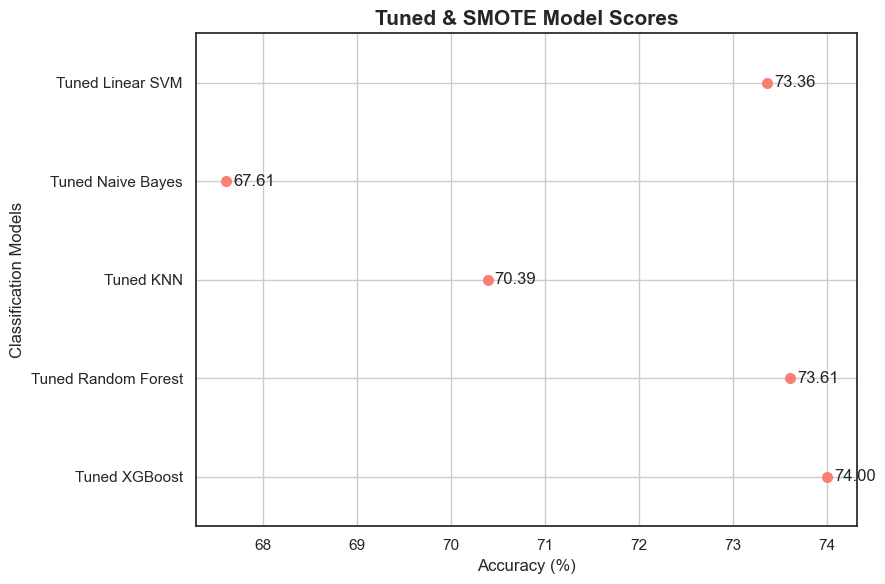

In [ ]:
fig, ax = plt.subplots(figsize=(9,6))

# Plot the stripplot
sns.stripplot(x=tuning_scores.values(), 
              y=tuning_scores.keys(), 
              color='salmon',
              size=8, 
              jitter=True, 
              linewidth=0, 
              ax=ax)

# Set some information
ax.set_xlabel('Accuracy (%)')
ax.set_ylabel('Classification Models')
ax.grid(axis='x')
ax.grid(axis='y')
ax.set_title('Tuned & SMOTE Model Scores', fontweight='bold', fontsize=15)

# Annotate the dots
for i, accu in enumerate(tuning_scores.keys()):
    ax.annotate(f'{tuning_scores[accu]:.2f}',
                xy=(tuning_scores[accu], i),
                xytext=(5,0),
                textcoords='offset points',
                ha='left',
                va='center')

plt.tight_layout()
plt.show()

### Confusion Matrix of Tuned Scores

In [ ]:
tuning_scores

{'Tuned Linear SVM': 73.36190476190477,
 'Tuned Naive Bayes': 67.60952380952381,
 'Tuned KNN': 70.39047619047619,
 'Tuned Random Forest': 73.60952380952381,
 'Tuned XGBoost': 74.0}

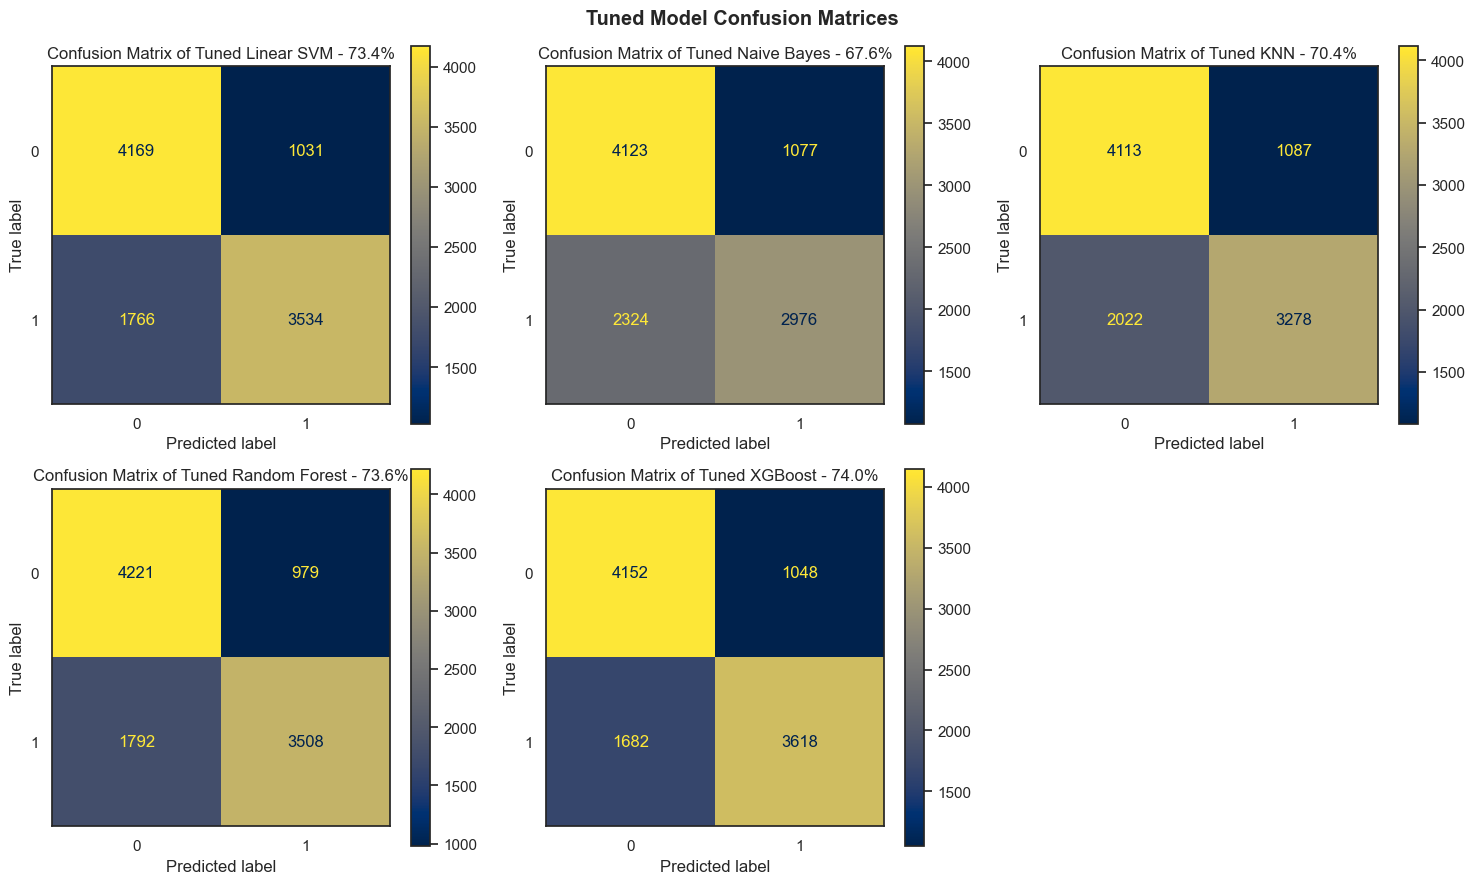

In [ ]:
# Import ConfusionMatrixDisplay from sklearn metrics
from sklearn.metrics import ConfusionMatrixDisplay

# Set some styling
sns.set(font_scale=1)
sns.set_style('white')

# Create a dictionary of the baseline models as key and their instance as the value
tuned_models = {'Tuned Linear SVM': rs_svc, 'Tuned Naive Bayes': rs_nb, 'Tuned KNN': rs_knn, 'Tuned Random Forest': rs_rf, 'Tuned XGBoost': rs_xgb}

# Create 2 by 3 plot
fig, axes = plt.subplots(nrows=2,
                         ncols=3,
                         figsize=(15,9))

# Flatten the axes for iteration
axes = axes.ravel()

# Use for loop to iterate every model, I also use enumerate so I can get the index for the axes
for i, (model, instance) in enumerate(tuned_models.items()):
    
    # Get score
    score = tuning_scores[model]

    # Make predictions per model
    y_preds = instance.predict(X_test)
    cm = confusion_matrix(y_test, y_preds)

    # Plot the confusion matrix of each model
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap = 'cividis', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix of {model} - {round(score, 1)}%')

# Remove any unused subplots
for blank in range(len(baseline_models), len(axes)):
    fig.delaxes(axes[blank])

# Add some information
fig.suptitle('Tuned Model Confusion Matrices', fontweight='bold')
plt.tight_layout()
plt.show()

## Step 8. Fit the best model to the training set and score

In [ ]:
rs_xgb.best_estimator_.fit(X_train, y_train, verbose=1)
rs_xgb.score(X_test, y_test)

0.7388571428571429

## Observations

* Overall, we observed that age, blood pressure, BMI, cholesterol, and glucose levels are more relevant features in predicting heart disease compared to lifestyle factors or occupation. It's important to note that the dataset might have limitations, such as a lack of specific details on certain lifestyle factors (e.g., the frequency of alcohol consumption, the amount of smoking), which could impact the predictive power of the model. Furthermore, to enhance the model's performance and avoid bias, it is advisable to collect more comprehensive data. We also noticed that the data related to country, gender, and occupation may have been selectively collected to avoid discrimination. Transparency in data collection is essential to ensure the model's reliability and trustworthiness.

* We can observe that tuned XGBoost achieve the highest accuracy of 74%. While this level of accuracy may be acceptable in some cases, it is not sufficient, especially for models that predict diseases. For such critical applications, achieving a higher level of accuracy is essential, as people's lives may depend on the reliability of these predictions. Therefore, further improvements and optimizations are needed to enhance the model performance and increase accuracy.
